# Figures: Predicting memorization

In [1]:
import sys

sys.path.append("/Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm")

## Setup

In [2]:
from grokking_llm.utils import (
    DeploymentCfg,
    TrainingCfg,
    get_p_smi_containers,
    get_pointwise_container,
    get_pointwise_layerwise_container,
)
from grokking_llm.measures_dyn import (
    SampleLossMetrics,
    MemoMembershipMetrics,
    MahalanobisMetrics,
    PSmiMetrics,
    PerfMetrics,
    GeneralMetrics,
)
from grokking_llm.training import (
    get_dataset,
    format_dataset,
    add_labels,
    get_random_split,
)

2024-09-20 09:02:45.533 | INFO     | grokking_llm.utils.logs:<module>:20 - Welcome to `grokking_llm` module!


2024-09-20 09:02:45.722 | INFO     | grokking_llm.utils.env_vars:<module>:15 - Found an environment var config at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/configs/env_vars.cfg, exporting its variables.
2024-09-20 09:02:45.725 | DEBUG    | grokking_llm.utils.env_vars:<module>:34 - Exporting env var OMP_NUM_THREADS=2
2024-09-20 09:02:45.728 | DEBUG    | grokking_llm.utils.hf_hub:<module>:32 - Setting env variable HF_HOME=/Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/.cache/huggingface
2024-09-20 09:02:45.729 | INFO     | grokking_llm.utils.hf_hub:<module>:37 - Config internet.offline = false
2024-09-20 09:02:45.730 | DEBUG    | grokking_llm.utils.hf_hub:<module>:49 - Looking for HF token at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/configs/credentials.cfg ...
2024-09-20 09:02:45.732 | INFO     | grokking_llm.utils.hf_hub:<module>:54 - Found HF token hf_*****************************xTkqH
2024-09-20 09:02:45.733 | DEBUG    | grokking_ll

In [65]:
import collections
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KernelDensity

## Loading

In [4]:
setup_names = [
    "arc__mis",
    "ethi_mis",
    "mmlu_mis",
    "mmlu_lla",
    "mmlu_gem",
]
cfg = {
    "arc__mis": TrainingCfg.autoconfig("wd1y"),
    "ethi_mis": TrainingCfg.autoconfig("M-H-"),
    "mmlu_mis": TrainingCfg.autoconfig("Ji5O"),
    "mmlu_lla": TrainingCfg.autoconfig("0K1p"),
    "mmlu_gem": TrainingCfg.autoconfig("dRfd"),
}
dep_cfg = {
    "arc__mis": DeploymentCfg.autoconfig("H5gQ"),
    "ethi_mis": DeploymentCfg.autoconfig("JNey"),
    "mmlu_mis": DeploymentCfg.autoconfig("Z5n7"),
    "mmlu_lla": DeploymentCfg.autoconfig("ZfTT"),
    "mmlu_gem": DeploymentCfg.autoconfig("mD9I"),
}
checkpoints = {
    "arc__mis": [50,100,150,200,250,1000,1750,2500],
    "ethi_mis": [397,794,1191,1588,1985,7940,13895,19850],
    "mmlu_mis": [750,1500,2250,3000,3750,15000,26250,37500],
    "mmlu_lla": [750,1500,2250,3000,3750,15000,26250,37500],
    "mmlu_gem": [750,1500,2250,3000,3750,15000,26250,37500],
}

2024-09-20 09:03:26.830 | INFO     | grokking_llm.utils.training_cfg:autoconfig:383 - Autoconfig `name`: wd1y is the prefix of confi_id wd1yKu7ifTBhJncAHIe3vA in `paths.individual_outputs`, building from it.
2024-09-20 09:03:26.840 | WARNING  | grokking_llm.utils.training_cfg:__init__:729 - Your configuration is not compatible with the following device: cuda. This is likely to cause errors in yoru pipeline.
2024-09-20 09:03:26.842 | WARNING  | grokking_llm.utils.training_cfg:__init__:735 - You selected `cuda` accelerator, but it is not available. CPU will be used instead.
2024-09-20 09:03:26.852 | INFO     | grokking_llm.utils.training_cfg:autoconfig:383 - Autoconfig `name`: M-H- is the prefix of confi_id M-H-RqkPbMpWRGgOcg-PRA in `paths.individual_outputs`, building from it.
2024-09-20 09:03:26.856 | WARNING  | grokking_llm.utils.training_cfg:__init__:729 - Your configuration is not compatible with the following device: cuda. This is likely to cause errors in yoru pipeline.
2024-09-20

In [5]:
checkpoint_to_epoch = collections.defaultdict(dict)
for setup in setup_names:
    for idx_chk, chk in enumerate(checkpoints[setup]):
        checkpoint_to_epoch[setup][chk] = {
            0: 0.2,
            1: 0.4,
            2: 0.6,
            3: 0.8,
            4: 1.0,
            5: 4.0,
            6: 7.0,
            7: 10.0,
        }[idx_chk]

In [6]:
global_idx = {}
for setup in setup_names:
    train_ds = get_dataset(cfg[setup], split="train")
    train_ds = format_dataset(train_ds, cfg[setup])
    train_ds = add_labels(train_ds, cfg[setup], split="train")
    train_ds = get_random_split(train_ds, cfg[setup])
    global_idx[setup] = train_ds["global_index"]

for setup in setup_names:
    print(f"[{setup}] {len(global_idx[setup])} elements")

2024-09-20 09:03:32.320 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 09:03:32.321 | INFO     | grokking_llm.training.datasets:format_dataset:174 - Formatting dataset ai2_arc
2024-09-20 09:03:32.322 | DEBUG    | grokking_llm.training.datasets:format_dataset:175 - Using seed=0 and force_template=False for formatting.
Map: 100%|██████████| 2000/2000 [00:00<00:00, 5013.22 examples/s]
2024-09-20 09:03:32.729 | INFO     | grokking_llm.training.datasets:add_labels:233 - Adding labels to dataset ai2_arc
2024-09-20 09:03:32.730 | DEBUG    | grokking_llm.training.datasets:add_labels:234 - Using proportion label_noise=0.03334 with seed=0
Map: 100%|██████████| 2000/2000 [00:00<00:00, 11027.06 examples/s]
2024-09-20 09:03:32.921 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 09:03:32.922 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using sp

[arc__mis] 1000 elements
[ethi_mis] 7940 elements
[mmlu_mis] 15000 elements
[mmlu_lla] 15000 elements
[mmlu_gem] 15000 elements


### Containers - memorization

In [7]:
def sanityze(memo_per_chk_per_idx):

    num_changed = 0

    for chk in memo_per_chk_per_idx:
        for idx in memo_per_chk_per_idx[chk]:
            old_val = memo_per_chk_per_idx[chk][idx]
            memo_per_chk_per_idx[chk][idx] = max(-100.0, memo_per_chk_per_idx[chk][idx])
            memo_per_chk_per_idx[chk][idx] = min(100.0, memo_per_chk_per_idx[chk][idx])
            
            if old_val != memo_per_chk_per_idx[chk][idx]:
                num_changed += 1

    print(f"Num item changed: {num_changed}")

In [8]:
memo_per_setup_per_chk_per_idx = {}
for setup in setup_names:
    memo = MemoMembershipMetrics(cfg[setup], dep_cfg[setup])
    memo_df = memo.load_metrics_df()
    memo_per_setup_per_chk_per_idx[setup] = get_pointwise_container(memo_df, memo.column_offset)
    sanityze(memo_per_setup_per_chk_per_idx[setup])

2024-09-20 09:04:22.870 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__init__:48 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 09:04:26.059 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 09:04:26.066 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 09:04:26.067 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 09:04:26.074 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_H5gQZhfMsLE5_NTX9hR7TA` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 09:04:26.077 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/indi

Num item changed: 145


2024-09-20 09:04:28.692 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset hendrycks/ethics split train
2024-09-20 09:04:28.699 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset hendrycks/ethics
2024-09-20 09:04:28.700 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=7940
2024-09-20 09:04:28.731 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_JNeyT5OUP3GFtJ_QNojppg` on config M-H-RqkPbMpWRGgOcg-PRA
2024-09-20 09:04:28.733 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/M-H-RqkPbMpWRGgOcg-PRA/metrics/memo_on_shadow_JNeyT5OUP3GFtJ_QNojppg.csv
2024-09-20 09:04:28.734 | DEBUG    | grokking_llm.measures_dyn.memo_membership_

Num item changed: 5314


2024-09-20 09:04:34.736 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-20 09:04:34.750 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-20 09:04:34.751 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-20 09:04:34.823 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_Z5n7bEDGK4JRT4HyLKSzrw` on config Ji5OIUTJGuYCYhAzj6KtZQ
2024-09-20 09:04:34.826 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/Ji5OIUTJGuYCYhAzj6KtZQ/metrics/memo_on_shadow_Z5n7bEDGK4JRT4HyLKSzrw.csv
2024-09-20 09:04:34.827 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__ini

Num item changed: 4584


2024-09-20 09:04:42.899 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-20 09:04:42.910 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-20 09:04:42.912 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-20 09:04:42.966 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_ZfTT7SCYBAzBtjT3_sy3wg` on config 0K1pZkoAv45RZXOIJl9kFw
2024-09-20 09:04:42.969 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/0K1pZkoAv45RZXOIJl9kFw/metrics/memo_on_shadow_ZfTT7SCYBAzBtjT3_sy3wg.csv
2024-09-20 09:04:42.970 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__ini

Num item changed: 193


2024-09-20 09:04:50.955 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-20 09:04:50.965 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-20 09:04:50.966 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-20 09:04:51.031 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_mD9ImObzoCshT5dpStKiMA` on config dRfdcYPXxygGJ2kuZfsYew
2024-09-20 09:04:51.035 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/dRfdcYPXxygGJ2kuZfsYew/metrics/memo_on_shadow_mD9ImObzoCshT5dpStKiMA.csv
2024-09-20 09:04:51.036 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__ini

Num item changed: 71


### Containers - PSMI

In [9]:
p_smi_per_setup_per_chk_per_layer_per_idx = {}
for setup in setup_names:
    p_smi = PSmiMetrics(cfg[setup])
    p_smi_df = p_smi.load_metrics_df(authorized_checkpoints=checkpoints[setup][0:5])
    p_smi_per_setup_per_chk_per_layer_per_idx[setup] = get_p_smi_containers(p_smi_df)[0]

2024-09-20 09:04:56.046 | INFO     | grokking_llm.measures_dyn.p_smi_metrics:__init__:37 - Initializing a PSmiMetrics with 2000 estimators, and full_dataset=False.
2024-09-20 09:04:56.048 | DEBUG    | grokking_llm.measures_dyn.p_smi_metrics:__init__:43 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 09:04:59.248 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 09:04:59.254 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 09:04:59.255 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 09:04:59.261 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `p_smi_metrics` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 09:04:59.263 | DEBUG    | grokking_llm.measures_dyn.dynamic_

### Containers - Loss and Mahalanobis

In [10]:
loss_per_setup_per_chk_per_idx = {}
for setup in setup_names:
    loss = SampleLossMetrics(cfg[setup])
    loss_df = loss.load_metrics_df(authorized_checkpoints=checkpoints[setup][0:5])
    loss_per_setup_per_chk_per_idx[setup] = get_pointwise_container(loss_df, loss.column_offset)

2024-09-20 09:18:17.223 | DEBUG    | grokking_llm.measures_dyn.sample_loss_metrics:__init__:23 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 09:18:20.741 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 09:18:20.748 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 09:18:20.749 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 09:18:20.754 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `sample_loss` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 09:18:20.761 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/wd1yKu7ifTBhJncAHIe3vA/

In [11]:
mahd_per_setup_per_chk_per_layer_per_idx = {}
for setup in setup_names:
    mahd = MahalanobisMetrics(cfg[setup])
    mahd_df = mahd.load_metrics_df(authorized_checkpoints=checkpoints[setup][0:5])
    mahd_per_setup_per_chk_per_layer_per_idx[setup] = get_pointwise_layerwise_container(mahd_df)

2024-09-20 09:18:38.200 | INFO     | grokking_llm.measures_dyn.mahalanobis_metrics:__init__:29 - Initializing a MahalanobisMetrics estimator.
2024-09-20 09:18:38.203 | DEBUG    | grokking_llm.measures_dyn.mahalanobis_metrics:__init__:32 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 09:18:41.146 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 09:18:41.152 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 09:18:41.154 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 09:18:41.159 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `mahalanobis_metrics` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 09:18:41.162 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_gr

### Container - General

In [12]:
perf_df_per_setup = {}
for setup in setup_names:
    general_df = GeneralMetrics(cfg[setup]).load_metrics_df()
    perf = PerfMetrics(cfg[setup])
    perf_df_per_setup[setup] = perf.load_metrics_df().merge(general_df[["checkpoint", "epoch"]], on="checkpoint", how="left")

2024-09-20 09:23:09.546 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `general` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 09:23:09.549 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/wd1yKu7ifTBhJncAHIe3vA/metrics/general.csv
2024-09-20 09:23:12.603 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 09:23:12.608 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 09:23:12.610 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 09:23:12.613 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `perf_metrics`

In [32]:
PRETTY_SETUP = {
    "arc__mis": "ARC/Mistral",
    "ethi_mis": "ETHICS/Mistral",
    "mmlu_mis": "MMLU/Mistral",
    "mmlu_lla": "MMLU/Llama",
    "mmlu_gem": "MMLU/Gemma",
}

In [64]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Plotting - memorization

In [67]:
BINS = 100
MIN_X = -100
MAX_X = 100
BANDWIDTH=1

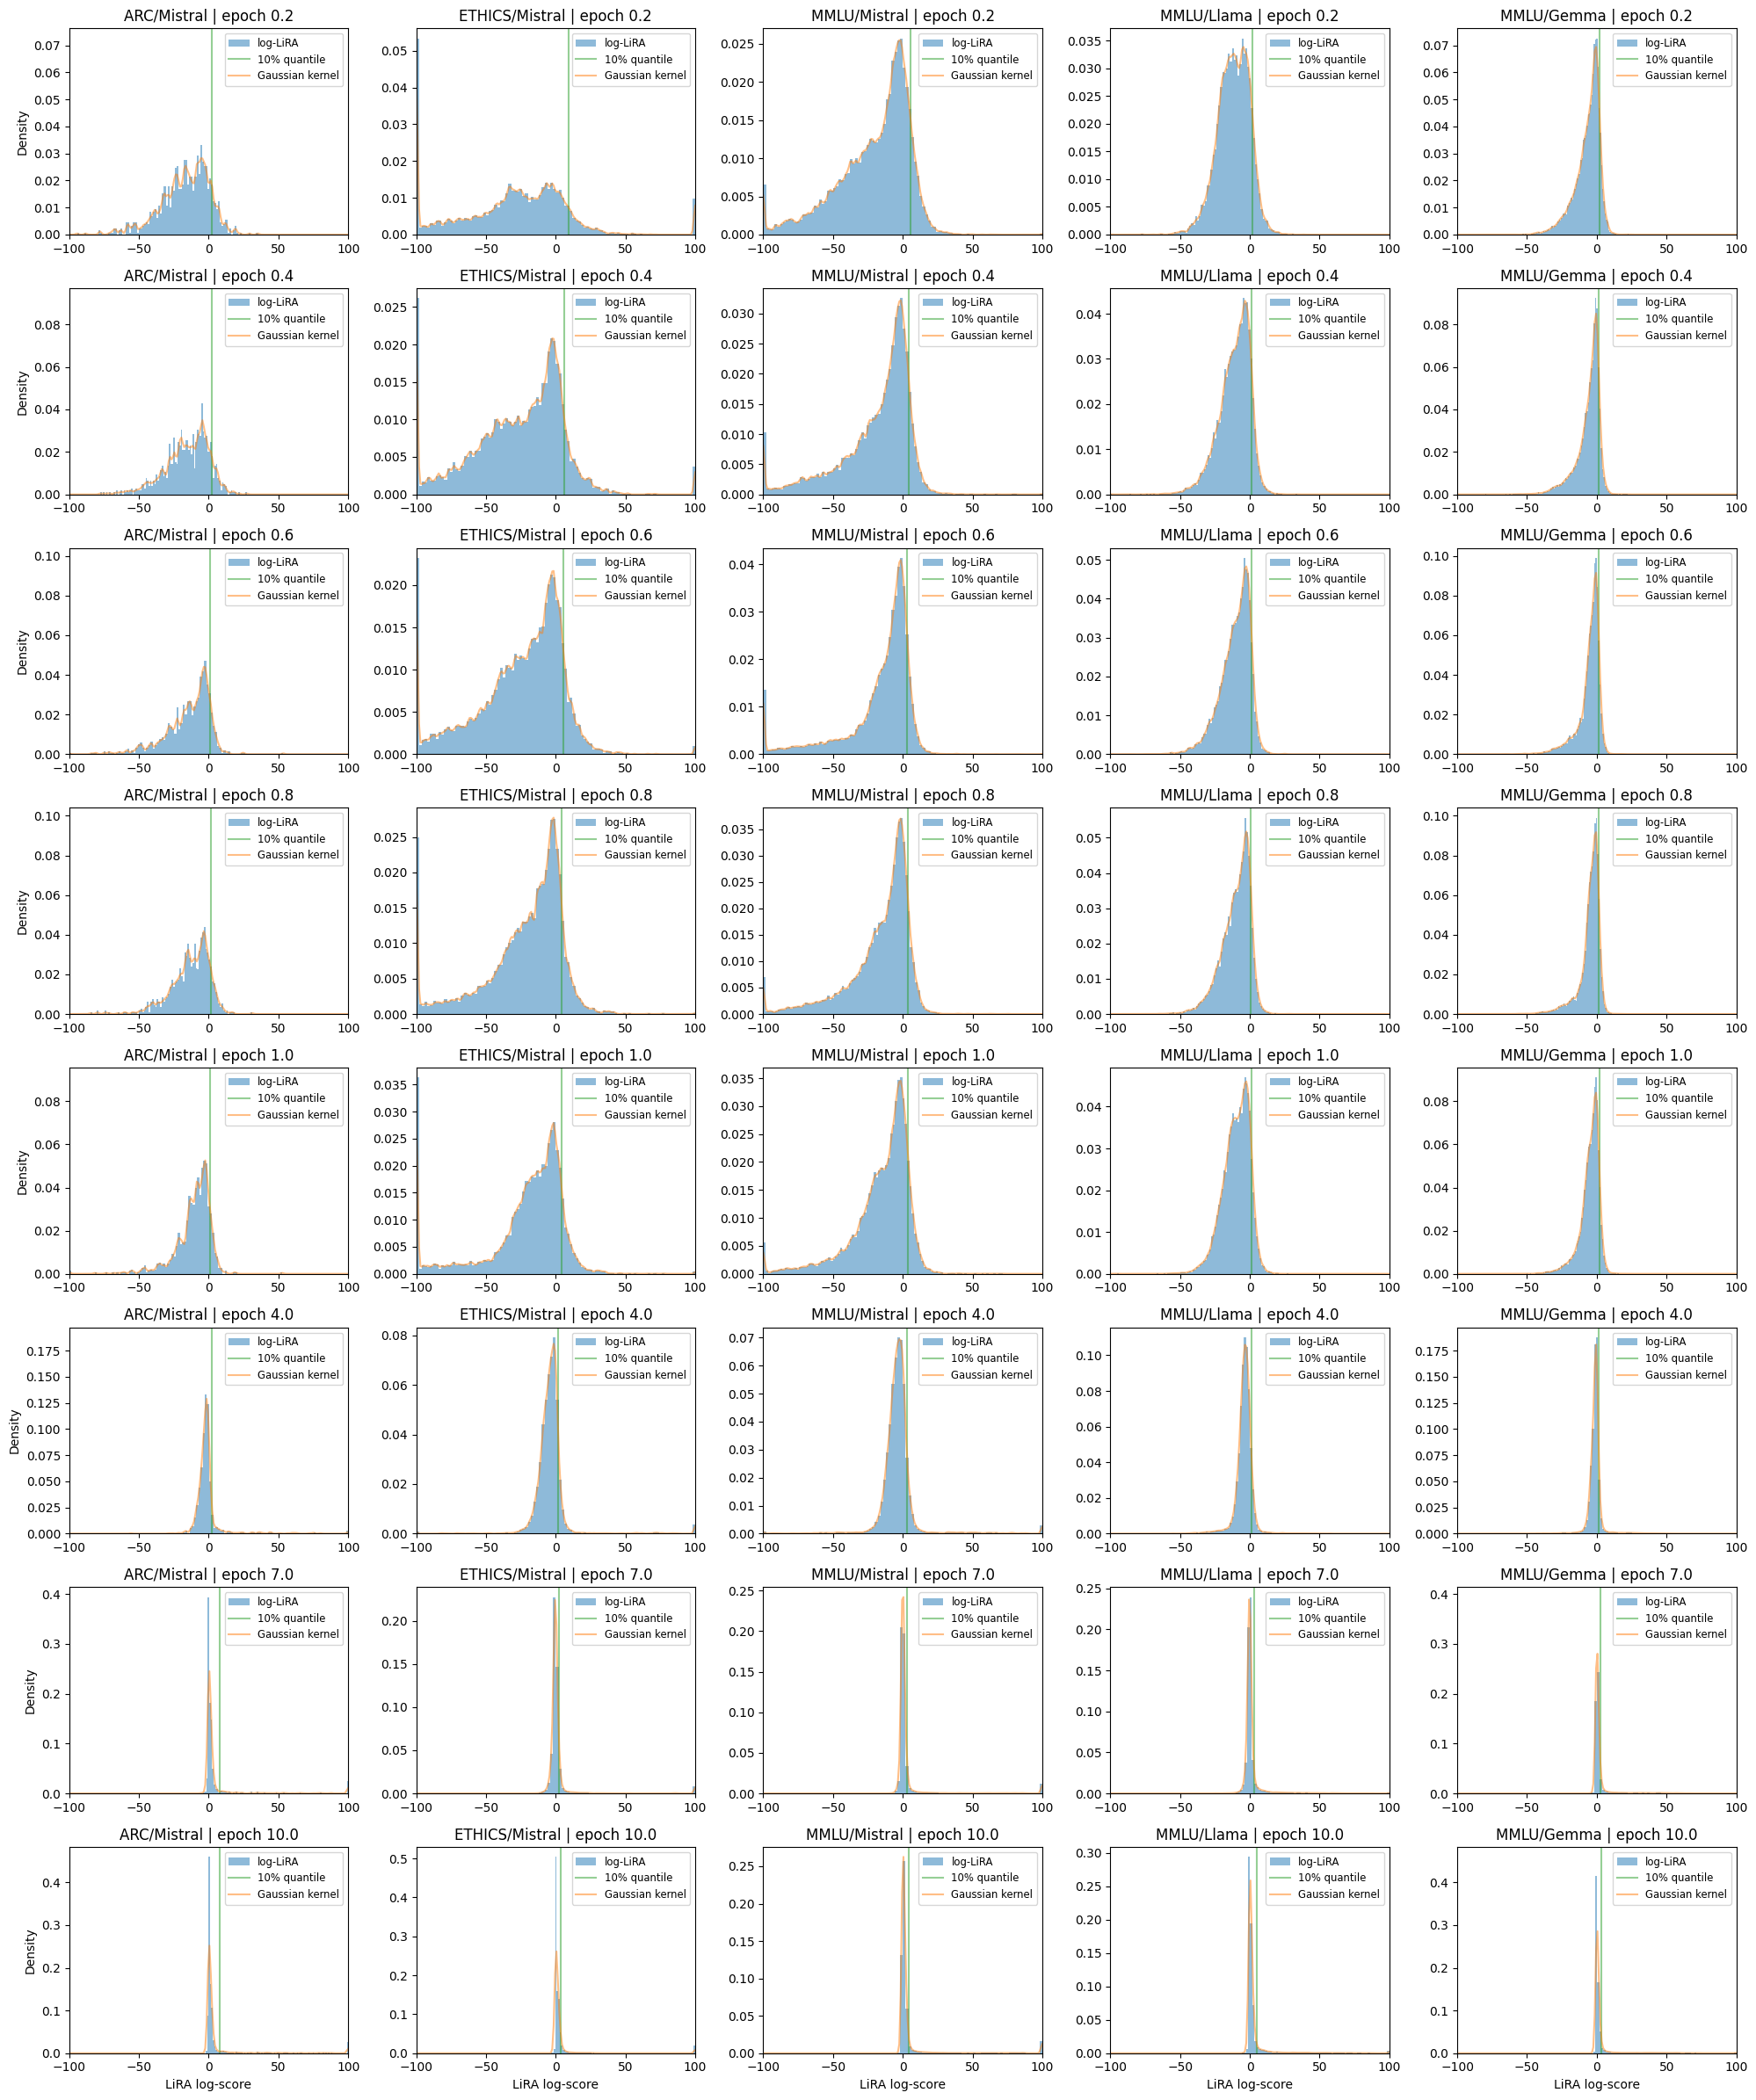

In [98]:
n_rows = len(checkpoints["mmlu_mis"])
n_cols = len(checkpoints)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

for idx_col, setup in enumerate(setup_names):
    for idx_row, chk in enumerate(checkpoints[setup]):
        ax = axs[idx_row, idx_col]

        # Memo
        memo = np.array([memo_per_setup_per_chk_per_idx[setup][chk][idx] for idx in global_idx[setup]]).reshape(-1, 1)

        # Plot
        ax.hist(memo, bins=BINS, density=True, alpha=.5, label="log-LiRA", color=COLORS[0])
        quantile = np.quantile(memo, q=.9)
        ax.axvline(quantile, linestyle="-", alpha=.5, label=f"10% quantile", color=COLORS[2])

        # Kernel estimation
        x_estimation = np.linspace(MIN_X, MAX_X, 200).reshape(-1, 1)
        kde = KernelDensity(kernel="gaussian", bandwidth=BANDWIDTH).fit(memo)
        x_likelihood = np.exp(kde.score_samples(x_estimation))
        ax.plot(x_estimation, x_likelihood, label="Gaussian kernel", alpha=.5, color=COLORS[1])


        ax.set_title(f"{PRETTY_SETUP[setup]} | epoch {checkpoint_to_epoch[setup][chk]}")
        ax.set_xlim(MIN_X, MAX_X)
        ax.legend(loc="upper right", fontsize="small")

        if idx_row == n_rows - 1:
            ax.set_xlabel("LiRA log-score")
        if idx_col == 0:
            ax.set_ylabel("Density")
            ax.sharey(axs[idx_row, -1])

fig.tight_layout()
fig.savefig("appendix_memo_histograms.pdf")

## Predict PSMI - impact of the depth

In [15]:
DEFAULT_PRED_INDEX = {
    "arc__mis": 1,
    "ethi_mis": 1,
    "mmlu_mis": 0,
    "mmlu_lla": 1,
    "mmlu_gem": 0,
}

In [16]:
TPR_OBJ = 0.75
MEMO_PROP = 0.90
INDEX_MEMO = -1

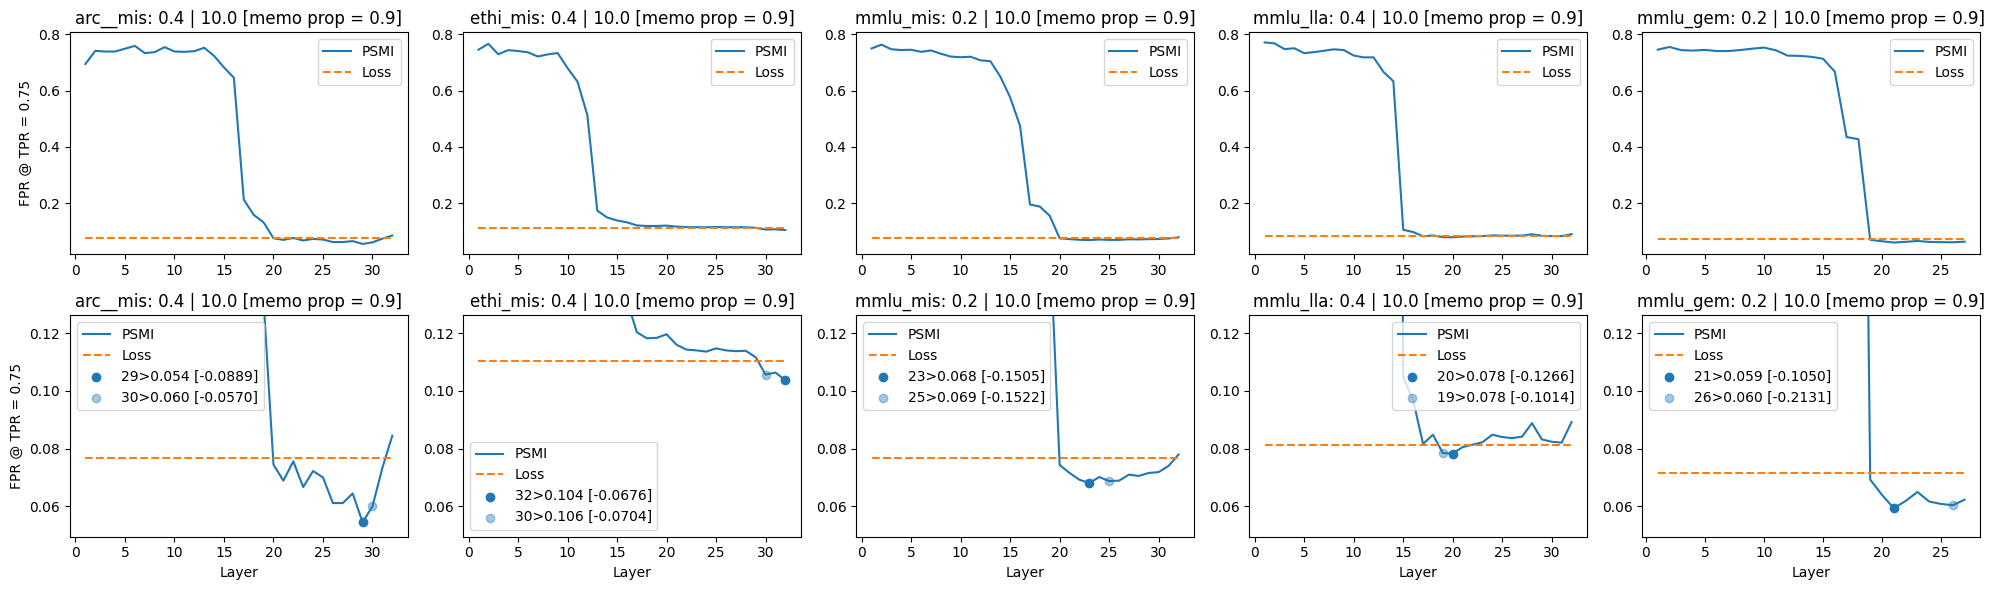

In [17]:
tpr_obj_list = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
n_cols = len(setup_names)
n_rows = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

min_val = 1
max_val = 0
for idx_col, setup in enumerate(setup_names):

    # Checkpoints
    chk_pred = checkpoints[setup][DEFAULT_PRED_INDEX[setup]]
    chk_memo = checkpoints[setup][INDEX_MEMO]

    # Predictors
    predictors = {
        layer: (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][layer][idx] for idx in global_idx[setup]],
            True,
        )
        for layer in cfg[setup].all_layers
    } | {
        "LOSS       ": (
            [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            False,
        ),
    }

    # Iterating over predictors
    fpr_at_layer = {}
    pred_thd = {}
    fpr_loss = None
    for pred_name, (pred, reversed) in predictors.items():
        memo = [memo_per_setup_per_chk_per_idx[setup][chk_memo][idx] for idx in global_idx[setup]]
        if reversed:
            pred = [-1 * item for item in pred]
        
        # Sorting 
        sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
        nan_index = set([
            idx for idx in range(len(pred))
            if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
        ])
        memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
        pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

        # Who is memorized ?
        memo_thd = np.quantile(memo, q=MEMO_PROP)
        is_memorized = [item >= memo_thd for item in memo]

        # Prec-rec curve
        fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

        # FPR @ 0.8 TPR
        for final_fpr, final_tpr, final_thd in zip(fpr, tpr, thd):
            if final_tpr > TPR_OBJ:
                break

        if type(pred_name) == int:
            fpr_at_layer[pred_name] = final_fpr
            pred_thd[pred_name] = -1 * final_thd
        elif "LOSS" in pred_name:
            fpr_loss = final_fpr
        else:
            raise ValueError(f"Unknow pred name: {pred_name}")

    layers = sorted(fpr_at_layer.keys())
    values = [fpr_at_layer[l] for l in layers]
    thresholds = [pred_thd[l] for l in layers]
    sorting_idx = sorted(range(len(values)), key=lambda k: values[k])
    min_fpr, next_min_fpr = values[sorting_idx[0]], values[sorting_idx[1]]
    min_thd, next_min_thd = thresholds[sorting_idx[0]], thresholds[sorting_idx[1]]
    min_layer, next_min_layer = layers[sorting_idx[0]], layers[sorting_idx[1]]

    # Plotting
    for idx_ax in range(2):
        ax = axs[idx_ax, idx_col]

        ax.plot(layers, values, label=f"PSMI")
        ax.plot(layers, [fpr_loss for _ in layers], label=f"Loss", linestyle="--")

        # Plot details
        ax.set_title(f"{setup}: {checkpoint_to_epoch[setup][chk_pred]} | {checkpoint_to_epoch[setup][chk_memo]} [memo prop = {MEMO_PROP}]")
        if idx_ax == n_rows - 1:
            ax.set_xlabel("Layer")
        if idx_col == 0:
            ax.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")
        else:
            ax.sharey(axs[idx_ax, idx_col - 1])

        # Scatter
        if idx_ax == 1:
            ax.scatter(min_layer, min_fpr, color=COLORS[0], label=f"{min_layer}>{min_fpr:.3f} [{min_thd:.4f}]")
            ax.scatter(next_min_layer, next_min_fpr, color=COLORS[0], alpha= 0.4, label=f"{next_min_layer}>{next_min_fpr:.3f} [{next_min_thd:.4f}]")

        # Y lim ?
        min_val = min(min_val, min(values) - 0.005)
        max_val = max(max_val, max(fpr_loss + 0.1*fpr_loss, values[-1]) + 0.005)
        if idx_ax == 1 and idx_col == n_cols - 1:
            ax.set_ylim(min_val, max_val)

        ax.legend()

fig.tight_layout()

In [51]:
DEFAULT_LAYERS = {
    "arc__mis": (29,30),
    "ethi_mis": (32,30),
    "mmlu_mis": (23,25),
    "mmlu_lla": (20,19),
    "mmlu_gem": (21,26),
}

## Plotting - General behavior

In [52]:
prop_to_evaluate = [0.95, 0.90, 0.80, 0.75]
top_memo_per_setup_per_prop = collections.defaultdict(dict)
for setup in setup_names:
    final_memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][-1]][idx] for idx in global_idx[setup]]
    final_memo = np.array(final_memo)
    for prop in prop_to_evaluate:
        top_memo_per_setup_per_prop[setup][prop] = np.quantile(final_memo, prop)

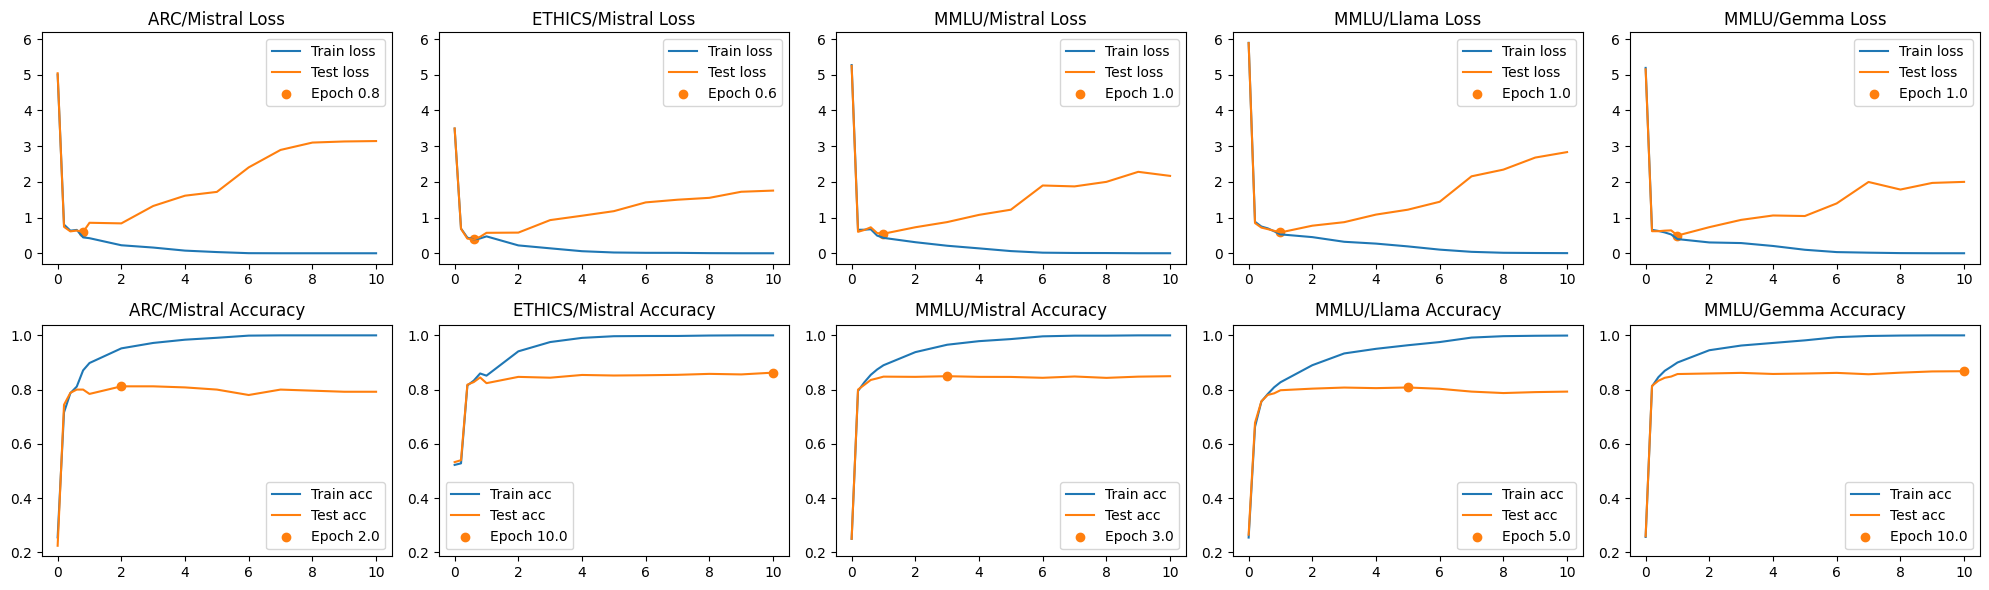

In [53]:
n_cols = len(setup_names)
n_rows = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows)) 

for idx_col, setup in enumerate(setup_names):

    # ====================== Loss ======================
    ax = axs[0, idx_col]
    ax.plot(perf_df_per_setup[setup]["epoch"], perf_df_per_setup[setup]["train_all_loss_asw"], label="Train loss")
    ax.plot(perf_df_per_setup[setup]["epoch"], perf_df_per_setup[setup]["test_loss_asw"], label="Test loss")
    
    # Scatter
    test_losses = perf_df_per_setup[setup]["test_loss_asw"]
    plot_checkpoints = perf_df_per_setup[setup]["epoch"]
    min_loss, min_loss_epoch = min(test_losses), plot_checkpoints[np.argmin(test_losses)]
    ax.scatter(min_loss_epoch, min_loss, color=COLORS[1], label=f"Epoch {min_loss_epoch}")
    
    ax.legend()
    ax.set_title(f"{PRETTY_SETUP[setup]} Loss")

    # Share y ?
    if idx_col > 0:
        ax.sharey(axs[0, 0])

    # ====================== Accuracy ======================
    ax = axs[1, idx_col]
    ax.plot(perf_df_per_setup[setup]["epoch"], perf_df_per_setup[setup]["train_all_accuracy"], label="Train acc")
    ax.plot(perf_df_per_setup[setup]["epoch"], perf_df_per_setup[setup]["test_accuracy"], label="Test acc")

    # Scatter
    test_accuracies = perf_df_per_setup[setup]["test_accuracy"]
    plot_checkpoints = perf_df_per_setup[setup]["epoch"]
    max_acc, max_acc_epoch = max(test_accuracies), plot_checkpoints[np.argmax(test_accuracies)]
    ax.scatter(max_acc_epoch, max_acc, color=COLORS[1], label=f"Epoch {max_acc_epoch}")

    ax.legend()
    ax.set_title(f"{PRETTY_SETUP[setup]} Accuracy")

    # Share y ?
    if idx_col > 0:
        ax.sharey(axs[1, 0])

fig.tight_layout()
fig.savefig("appendix_training_facts.pdf")

## Plotting - predicting memorization

In [54]:
TPR_OBJ = 0.7
MEMO_PROP = 0.90
INDEX_MEMO = -1

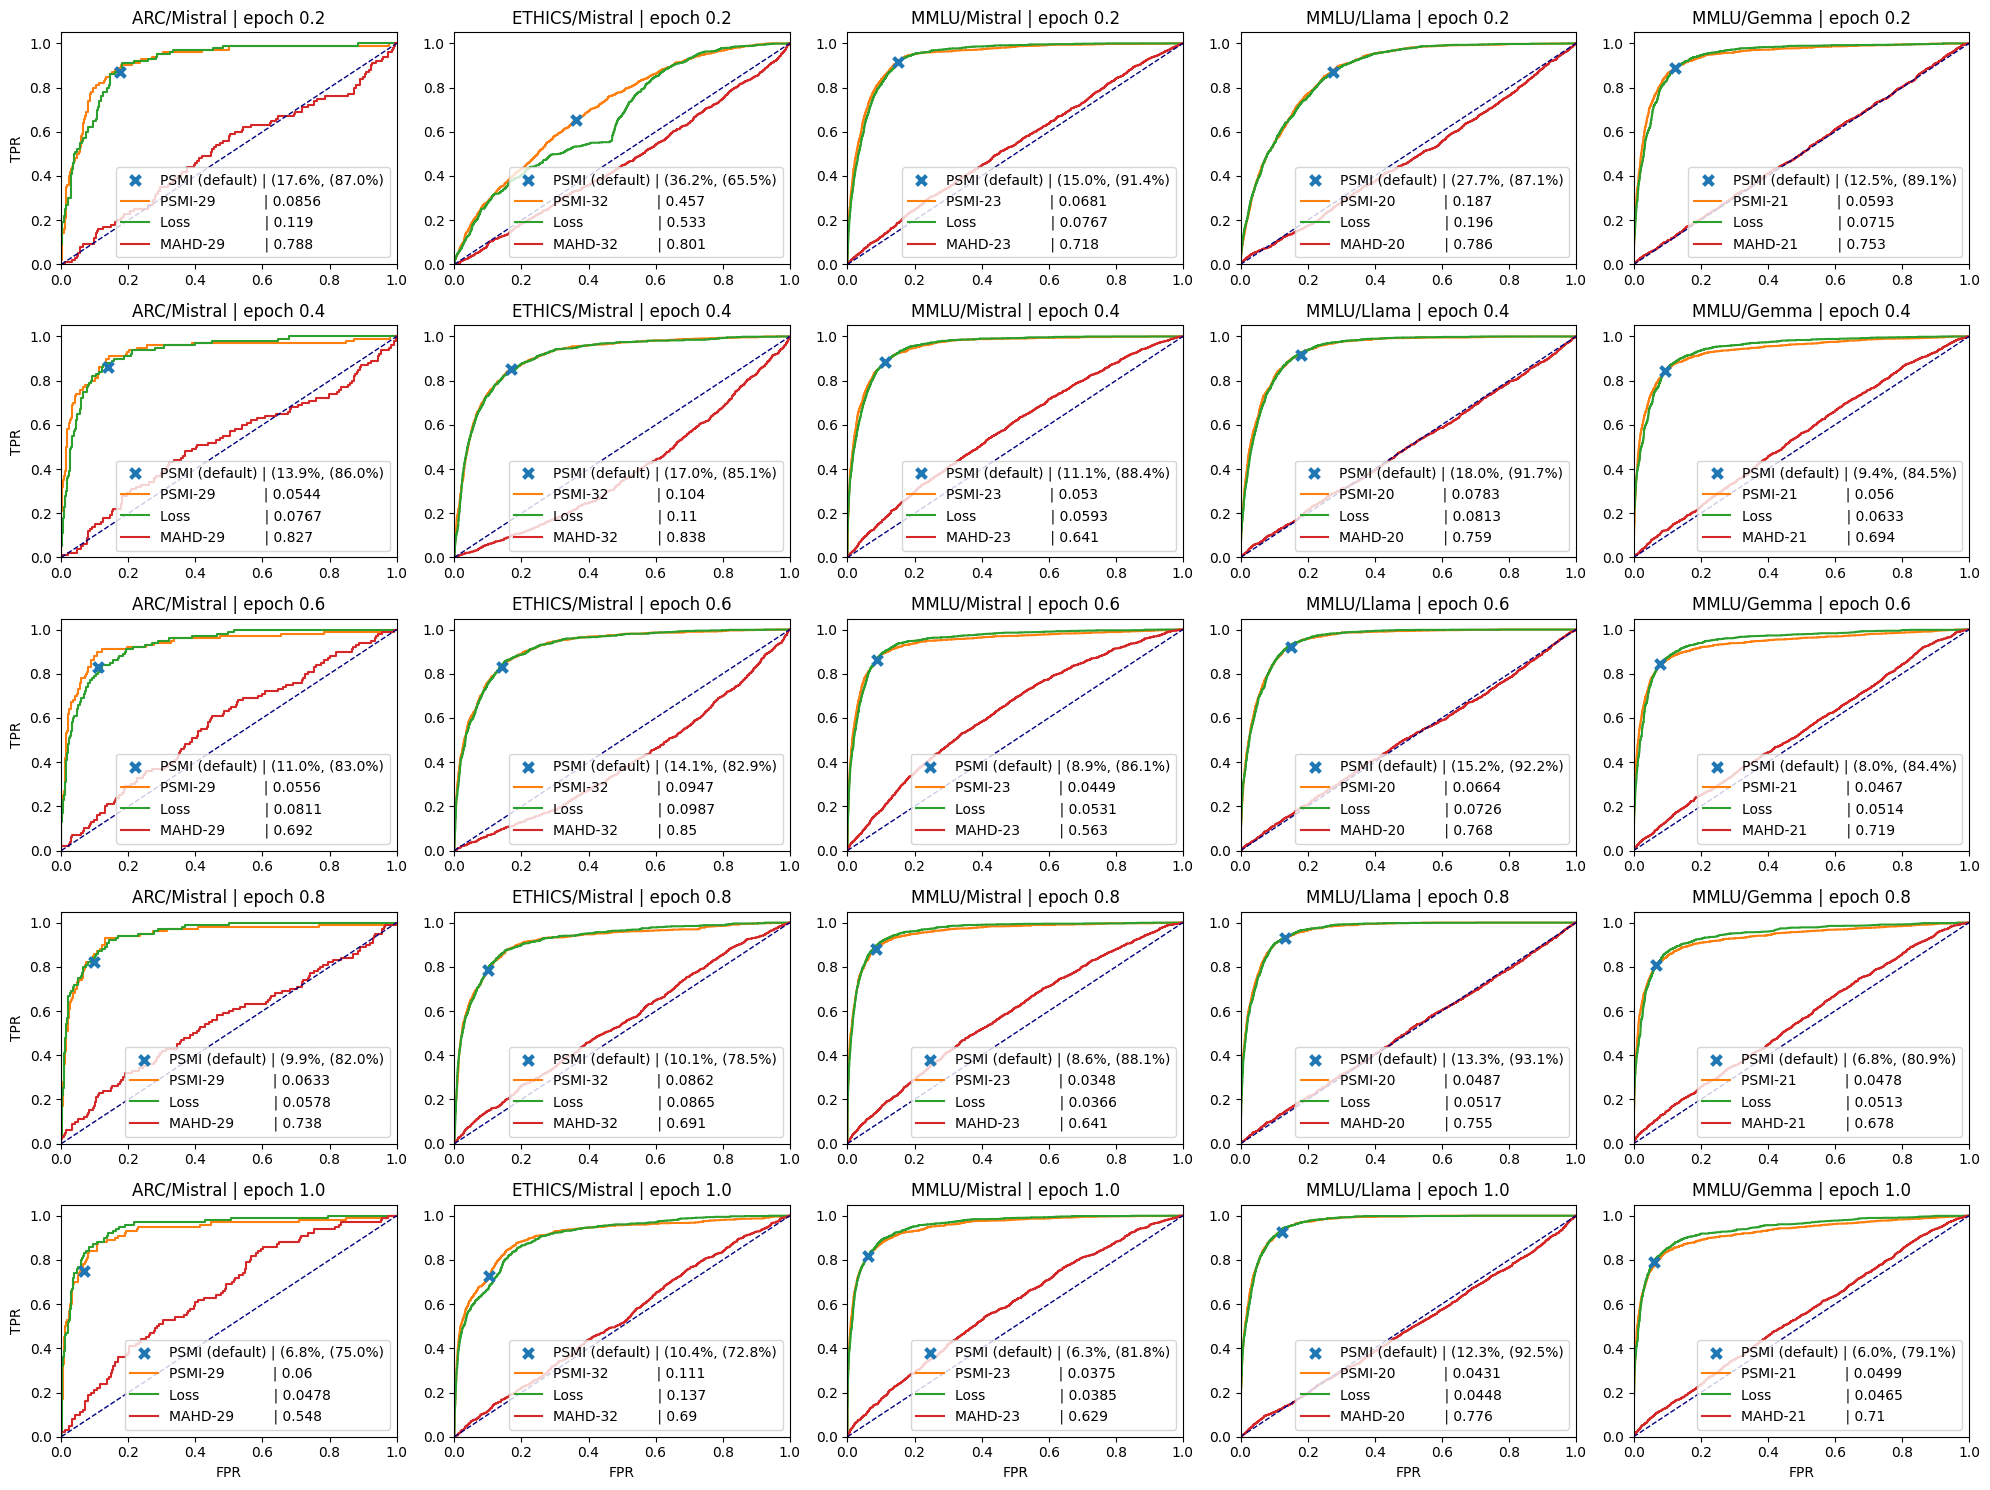

In [99]:
n_cols = len(setup_names)
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

for idx_col, setup in enumerate(setup_names):
    for idx_row, chk in enumerate(checkpoints[setup][0:5]):

        # Ax
        ax = axs[idx_row, idx_col]

        # Predictors
        best_layer, next_best_layer = DEFAULT_LAYERS[setup][0], DEFAULT_LAYERS[setup][1]
        last_layer = 32 if "gem" not in setup else 27
        predictors = {
            f"PSMI (default)": (
                [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk][last_layer][idx] for idx in global_idx[setup]],
                True,
            ),
            f"PSMI-{best_layer}          ": (
                [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk][best_layer][idx] for idx in global_idx[setup]],
                True,
            ),
            "Loss                ": (
                [loss_per_setup_per_chk_per_idx[setup][chk][idx] for idx in global_idx[setup]],
                False,
            ),
            f"MAHD-{best_layer}        ": (
                [mahd_per_setup_per_chk_per_layer_per_idx[setup][chk][best_layer][idx] for idx in global_idx[setup]],
                False,
            ),
        }

        # Iterating over predictors
        for idx_pred, (pred_name, (pred, reversed)) in enumerate(predictors.items()):
            memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
            if reversed:
                pred = [-1 * item for item in pred]
            
            # Sorting 
            sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
            nan_index = set([
                idx for idx in range(len(pred))
                if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
            ])
            memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
            pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

            # Who is memorized ?
            memo_thd = np.quantile(memo, q=MEMO_PROP)
            is_memorized = [item >= memo_thd for item in memo]

            # Prec-rec curve
            fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

            # FPR @ 0.8 TPR
            for final_fpr, final_tpr, final_thd in zip(fpr, tpr, thd):
                if final_tpr > TPR_OBJ and "default" not in pred_name:
                    break
                if final_thd < 0 and "default" in pred_name:
                    break


            if "default" in pred_name:
                label = f"{pred_name} | ({final_fpr:.1%}, ({final_tpr:.1%})"
                ax.scatter(final_fpr, final_tpr, marker="x", label=label, s=50, linewidths=3, zorder=10, color=COLORS[idx_pred])
            else:
                label = f"{pred_name} | {final_fpr:.3}"
                ax.plot(fpr, tpr, label=label, color=COLORS[idx_pred])

        # Plot details
        ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        # ax.plot([0, 1], [TPR_OBJ, TPR_OBJ], color='navy', lw=1, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])

        ax.set_title(f"{PRETTY_SETUP[setup]} | epoch {checkpoint_to_epoch[setup][chk]}")
        if idx_row == n_rows - 1:
            ax.set_xlabel("FPR")
        if idx_col == 0:
            ax.set_ylabel("TPR")
    
        ax.legend(loc="lower right")

fig.tight_layout()
fig.savefig("appendix_all_roc_curves.pdf")

## Predict memorization - impact of the memo threshold

In [77]:
TPR_OBJ = 0.75
MEMO_PROP = 0.90
INDEX_MEMO = -1

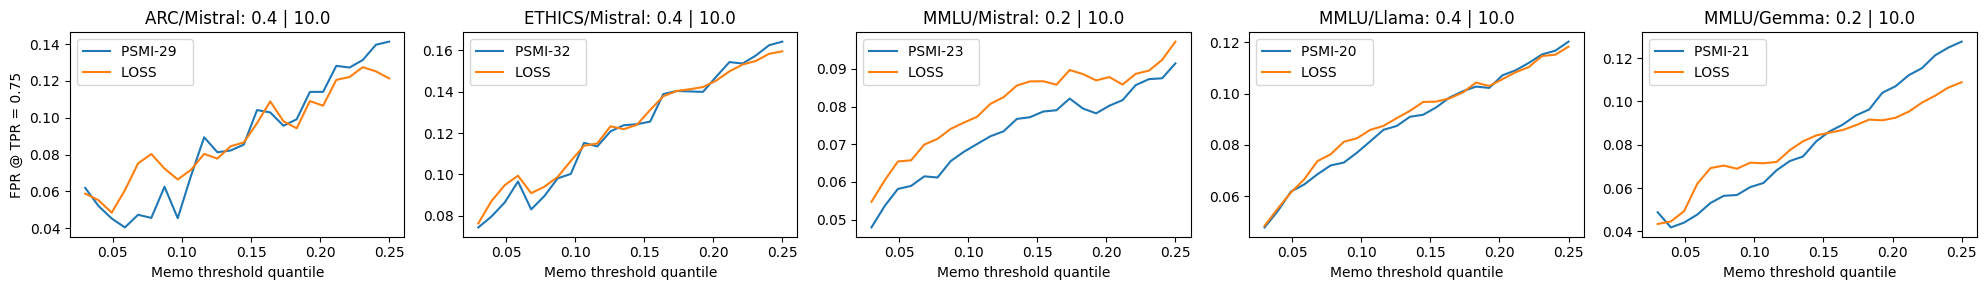

In [79]:
memo_quantiles = np.linspace(0.03, 0.25, 24)
n_cols = len(setup_names)
n_rows = 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

for idx_col, setup in enumerate(setup_names):

    # Ax
    ax = axs[idx_col]

    # Checkpoints
    chk_pred = checkpoints[setup][DEFAULT_PRED_INDEX[setup]]
    chk_memo = checkpoints[setup][INDEX_MEMO]

    # Predictors
    best_layer, next_best_layer = DEFAULT_LAYERS[setup][0], DEFAULT_LAYERS[setup][1]
    predictors = {
        f"PSMI-{best_layer}  ": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][best_layer][idx] for idx in global_idx[setup]],
            True,
        ),
        "LOSS       ": (
            [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            False,
        ),
    }

    # Iterating over predictors
    for pred_name, (pred, reversed) in predictors.items():
        memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
        if reversed:
            pred = [-1 * item for item in pred]
        
        # Sorting 
        sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
        nan_index = set([
            idx for idx in range(len(pred))
            if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
        ])
        memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
        pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

        # Who is memorized ?
        fpr_at = []
        for q in memo_quantiles:

            memo_thd = np.quantile(memo, q=1-q)
            is_memorized = [item >= memo_thd for item in memo]

            # Prec-rec curve
            fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

            # FPR @ 0.8 TPR
            for final_fpr, final_tpr in zip(fpr, tpr):
                if final_tpr > TPR_OBJ:
                    break

            fpr_at.append(final_fpr)

        ax.plot(memo_quantiles, fpr_at, label=f"{pred_name}")

    # Plot details

    ax.set_title(f"{PRETTY_SETUP[setup]}: {checkpoint_to_epoch[setup][chk_pred]} | {checkpoint_to_epoch[setup][chk_memo]}")
    ax.set_xlabel("Memo threshold quantile")
    if idx_col == 0:
        ax.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")

    ax.legend()

fig.tight_layout()
fig.savefig("appendix_quantile_every_setting.pdf")

## Predict memorization - impact of the memo checkpoint

In [58]:
TPR_OBJ = 0.75
MEMO_PROP = 0.90

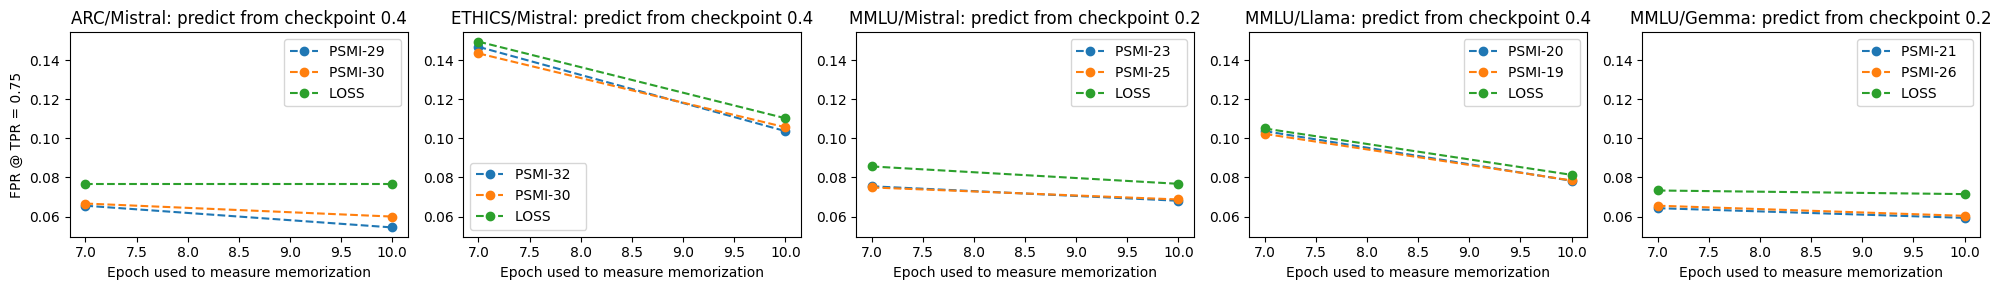

In [59]:
n_cols = len(setup_names)
n_rows = 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

for idx_col, setup in enumerate(setup_names):

    # Ax
    ax = axs[idx_col]

    # Checkpoints
    chk_pred = checkpoints[setup][DEFAULT_PRED_INDEX[setup]]

    # Predictors
    best_layer, next_best_layer = DEFAULT_LAYERS[setup][0], DEFAULT_LAYERS[setup][1]
    predictors = {
        f"PSMI-{best_layer}  ": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][best_layer][idx] for idx in global_idx[setup]],
            True,
        ),
        f"PSMI-{next_best_layer}  ": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][next_best_layer][idx] for idx in global_idx[setup]],
            True,
        ),
        "LOSS       ": (
            [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            False,
        ),
    }

    # Iterating over predictors
    for pred_name, (pred, reversed) in predictors.items():
        if reversed:
            pred = [-1 * item for item in pred]
        
        # Sorting 
        sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
        pred = [pred[idx] for idx in sorting_index]

        fpr_at = []
        epochs = []
        for chk_memo in checkpoints[setup][-2:]:
            memo = [memo_per_setup_per_chk_per_idx[setup][chk_memo][idx] for idx in global_idx[setup]]
            memo = [memo[idx] for idx in sorting_index if idx not in nan_index]

            # Who is memorized ?
            memo_thd = np.quantile(memo, q=MEMO_PROP)
            is_memorized = [item >= memo_thd for item in memo]

            # Prec-rec curve
            fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

            # FPR @ 0.8 TPR
            for final_fpr, final_tpr in zip(fpr, tpr):
                if final_tpr > TPR_OBJ:
                    break

            fpr_at.append(final_fpr)
            epochs.append(checkpoint_to_epoch[setup][chk_memo] )

        ax.plot(epochs, fpr_at, "o--", label=f"{pred_name}")

    # Plot details

    ax.set_title(f"{PRETTY_SETUP[setup]}: predict from checkpoint {checkpoint_to_epoch[setup][chk_pred]}")
    ax.set_xlabel("Epoch used to measure memorization")
    if idx_col == 0:
        ax.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")

    ax.legend()

    # Sharey
    if idx_col > 0:
        ax.sharey(axs[0])

fig.tight_layout()
fig.savefig("appendix_impact_checkpoint_memo.pdf")

## Predict memorization - impact of the predict checkpoint

In [60]:
TPR_OBJ = 0.75
MEMO_PROP = 0.90
INDEX_MEMO = -1

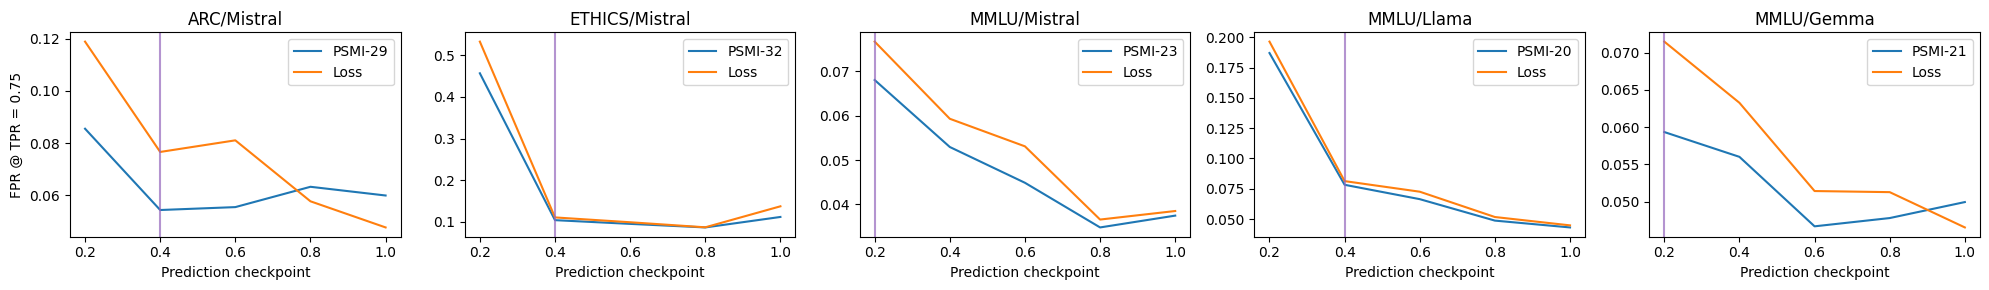

In [96]:
n_cols = len(setup_names)
n_rows = 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

for idx_col, setup in enumerate(setup_names):

    # Ax
    ax = axs[idx_col]

    # Checkpoints
    chk_memo = checkpoints[setup][INDEX_MEMO]

    fpr_at_per_pred = collections.defaultdict(list)
    chk_to_pred = checkpoints[setup][0:5]
    for chk_pred in chk_to_pred:

        # Predictors
        best_layer, next_best_layer = DEFAULT_LAYERS[setup][0], DEFAULT_LAYERS[setup][1]
        predictors = {
            f"PSMI-{best_layer}": (
                [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][best_layer][idx] for idx in global_idx[setup]],
                True,
            ),
            "Loss": (
                [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
                False,
            ),
        }

        # Iterating over predictors
        for pred_name, (pred, reversed) in predictors.items():
            memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
            if reversed:
                pred = [-1 * item for item in pred]
            
            # Sorting 
            sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
            nan_index = set([
                idx for idx in range(len(pred))
                if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
            ])
            memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
            pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

            # Who is memorized ?
            memo_thd = np.quantile(memo, q=MEMO_PROP)
            is_memorized = [item >= memo_thd for item in memo]

            # Prec-rec curve
            fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

            # FPR @ 0.8 TPR
            for final_fpr, final_tpr in zip(fpr, tpr):
                if final_tpr > TPR_OBJ:
                    break

            fpr_at_per_pred[pred_name].append(final_fpr)


    for pred_name in list(predictors):
        ax.plot([checkpoint_to_epoch[setup][chk] for chk in chk_to_pred], fpr_at_per_pred[pred_name], label=f"{pred_name}")

    # Plot details
    epoch_095 = checkpoint_to_epoch[setup][checkpoints[setup][DEFAULT_PRED_INDEX[setup]]]
    ax.axvline(epoch_095, color=COLORS[4], linestyle="-", alpha=.7)
    ax.set_title(f"{PRETTY_SETUP[setup]}")
    ax.set_xlabel("Prediction checkpoint")
    if idx_col == 0:
        ax.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")

    ax.legend()

fig.tight_layout()
fig.savefig("appendix_prediction_checkpoint.pdf")

## Predict memorization - impact of the TPR threshold

In [62]:
TPR_OBJ = 0.75
MEMO_PROP = 0.90
INDEX_MEMO = -1

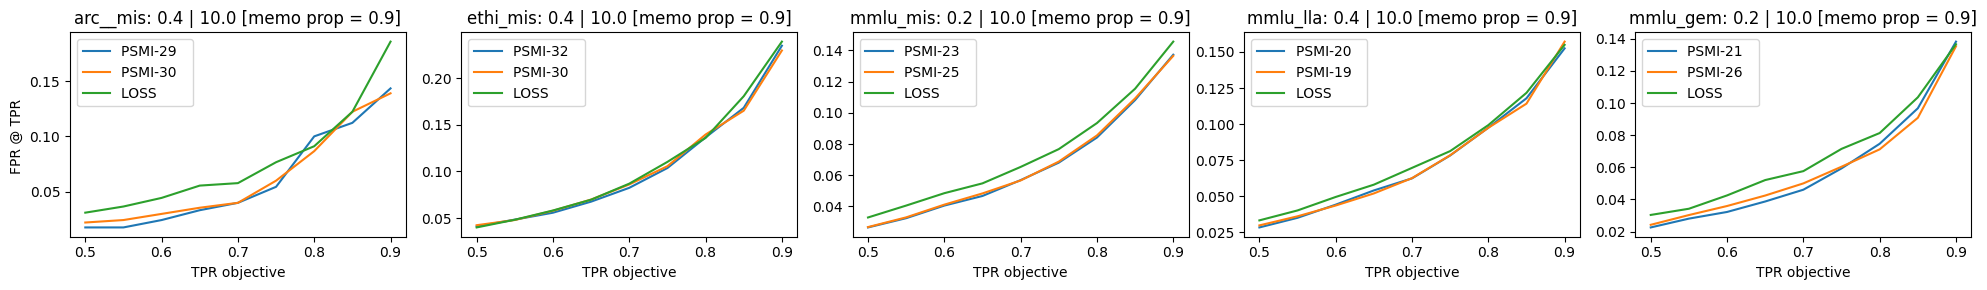

In [63]:
tpr_obj_list = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
n_cols = len(setup_names)
n_rows = 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

for idx_col, setup in enumerate(setup_names):

    # Ax
    ax = axs[idx_col]

    # Checkpoints
    chk_pred = checkpoints[setup][DEFAULT_PRED_INDEX[setup]]
    chk_memo = checkpoints[setup][INDEX_MEMO]

    # Predictors
    best_layer, next_best_layer = DEFAULT_LAYERS[setup][0], DEFAULT_LAYERS[setup][1]
    predictors = {
        f"PSMI-{best_layer}  ": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][best_layer][idx] for idx in global_idx[setup]],
            True,
        ),
        f"PSMI-{next_best_layer}  ": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][next_best_layer][idx] for idx in global_idx[setup]],
            True,
        ),
        "LOSS       ": (
            [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            False,
        ),
    }

    # Iterating over predictors
    for pred_name, (pred, reversed) in predictors.items():
        memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
        if reversed:
            pred = [-1 * item for item in pred]
        
        # Sorting 
        sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
        nan_index = set([
            idx for idx in range(len(pred))
            if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
        ])
        memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
        pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

        # Who is memorized ?
        memo_thd = np.quantile(memo, q=MEMO_PROP)
        is_memorized = [item >= memo_thd for item in memo]

        # Prec-rec curve
        fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

        fpr_at = []
        for final_fpr, final_tpr in zip(fpr, tpr):
            for idx, tpr_obj in enumerate(tpr_obj_list):
                if len(fpr_at) <= idx and final_tpr > tpr_obj:
                    fpr_at.append(final_fpr)

        ax.plot(tpr_obj_list, fpr_at, label=f"{pred_name}")

    # Plot details

    ax.set_title(f"{setup}: {checkpoint_to_epoch[setup][chk_pred]} | {checkpoint_to_epoch[setup][chk_memo]} [memo prop = {MEMO_PROP}]")
    ax.set_xlabel("TPR objective")
    if idx_col == 0:
        ax.set_ylabel(f"FPR @ TPR ")

    ax.legend()

fig.tight_layout()